In [1]:
import os.path as osp
import numpy as np
import pickle
import copy

import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch import nn
from torchvision import transforms
from torch import optim

import carla_visual as cv
from carla_visual.dataloaders.online_dataset import load_online_dataset, build_dataloader

from carla_visual.models.classifiers import PIECECNN
from carla_visual.models.generators import PIECEGenerator

from carla_visual.models.utils import fetch_weights, load_model_weights
import carla_visual.evaluation.evaluate_prediction_model as epm

from carla_visual.recourse_methods.piece import get_misclassifications, get_misclassificaiton, return_feature_contribution_data
from carla_visual.recourse_methods.piece import acquire_feature_probabilities, filter_df_of_exceptional_noise, optimize_z0, modifying_exceptional_features
from carla_visual.plotting.plot_output import plot_misclassifications

from carla_visual.plotting.plot_output import plot_image  

# Prepare data

In [2]:
ds_name = 'MNIST'
data_root = 'D:\PycharmProjects\XAIRobustness\data\images'

train_data, test_data = load_online_dataset(ds_name, data_root, download=False)
print(f'Shape of the train set: ', train_data.data.shape)
print(f'Shape of the test set: ', test_data.data.shape)

Shape of the train set:  torch.Size([60000, 28, 28])
Shape of the test set:  torch.Size([10000, 28, 28])


In [5]:
input_chn = 1
num_classes = 10
batch_size = 1
nz = 100
device = 'cuda' if torch.cuda.is_available() else 'cpu'
ngpu = 0 if device == 'cpu' else 1


In [6]:
train_dataloader, test_dataloader = build_dataloader([train_data, test_data], 
                                                      batch_size=batch_size, 
                                                      shuffle=True)

# Load pre-trained CNN and Generator 

In [7]:
original_cnn_weights = 'https://github.com/EoinKenny/AAAI-2021/raw/refs/heads/master/weights/pytorch_cnn.pth'
original_gen_weights = 'https://github.com/EoinKenny/AAAI-2021/raw/refs/heads/master/weights/generator.pth'

output_dir = 'D:\PycharmProjects\XAIRobustness\CARLA_VISUAL\carla_visual\models\weights\piece'
cnn_weights_file = 'cnn_weights.pth'
gen_weights_file = 'generator_weights.pth'


In [6]:
fetch_weights(original_cnn_weights, file_name=cnn_weights_file, output_dir=output_dir)
fetch_weights(original_gen_weights, file_name=gen_weights_file, output_dir=output_dir)

In [8]:
cnn = PIECECNN(input_chn, num_classes)
print('Total number of parameters in the CNN:', cnn.get_params_num())
cnn = load_model_weights(cnn, osp.join(output_dir, cnn_weights_file), device=device)


Total number of parameters in the CNN: 143162


In [ ]:
print('Accuracy of the pre-trained CNN: ', epm.evaluate_model(cnn, test_dataloader, device)['accuracy'])

In [10]:
gen = PIECEGenerator(ngpu=ngpu)
gen = load_model_weights(gen, osp.join(output_dir, gen_weights_file), device=device)

Check the generative performance of the loaded generator 

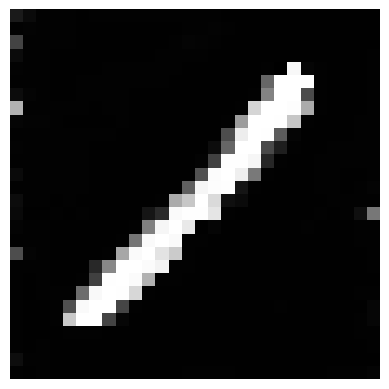

In [11]:
z = torch.randn(batch_size, nz)
z = z.view(z.size(0), nz, 1, 1)
generated_images = gen(z)
plot_image(generated_images) 

# PIECE Algorithm  #

1) Obtaining a misclassified instance with the specified index *k_misclf_num* 

In [12]:
original_query_idx, original_query_img, \
original_query_label, original_query_prediction = get_misclassificaiton(test_dataloader, cnn, k_misclf_num=2)

Label: 9
Prediction: 7


Visualize several missclassifications found in the whole test set 

In [9]:
misclf_samples = get_misclassifications(cnn, test_dataloader, device) 

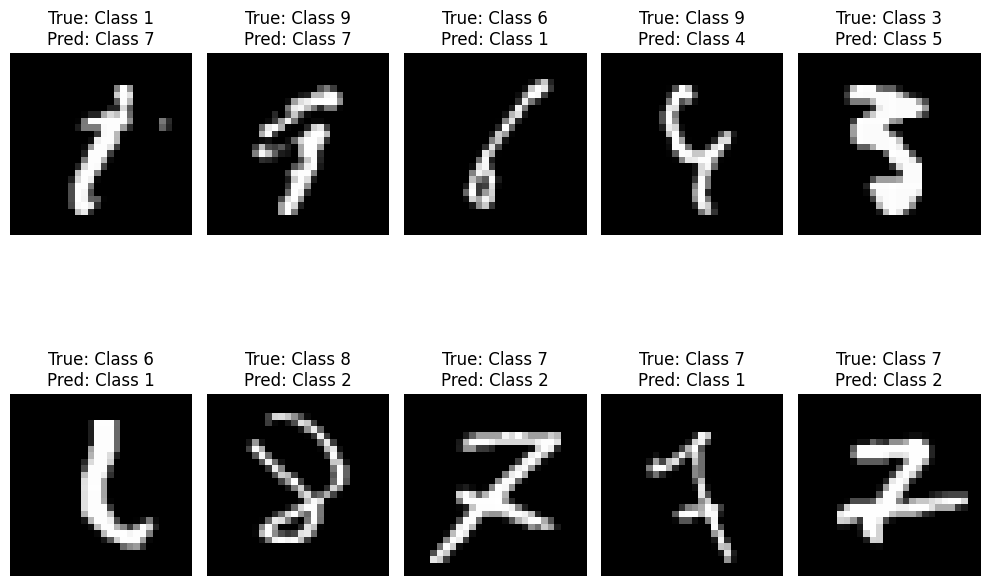

In [10]:
plot_misclassifications(misclf_samples)

2) Identifying the latent vector that corresponds to the given misclassified image

In [13]:
z_I = optimize_z0(gen, cnn.main, original_query_img, nz)

Iteration 0, Loss: 1995.59521484375
Iteration 100, Loss: 1341.150634765625
Iteration 200, Loss: 1462.3623046875
Iteration 300, Loss: 1196.8121337890625
Iteration 400, Loss: 1912.6634521484375
Iteration 500, Loss: 1080.0130615234375
Iteration 600, Loss: 972.4901123046875
Iteration 700, Loss: 902.74072265625
Iteration 800, Loss: 880.7911376953125
Iteration 900, Loss: 866.0821533203125
Iteration 1000, Loss: 857.4139404296875
Iteration 1100, Loss: 844.6631469726562
Iteration 1200, Loss: 828.5670166015625
Iteration 1300, Loss: 870.97802734375
Iteration 1400, Loss: 724.7532348632812
Iteration 1500, Loss: 721.1385498046875
Iteration 1600, Loss: 693.1408081054688
Iteration 1700, Loss: 733.3135375976562
Iteration 1800, Loss: 1141.7578125
Iteration 1900, Loss: 1098.91552734375
Iteration 2000, Loss: 1019.9920654296875
Iteration 2100, Loss: 776.8290405273438
Iteration 2200, Loss: 731.8163452148438
Iteration 2300, Loss: 717.49267578125
Iteration 2400, Loss: 712.331787109375
Iteration 2500, Loss: 70

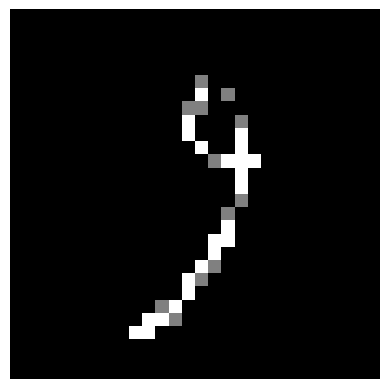

In [16]:
plot_image(original_query_img)

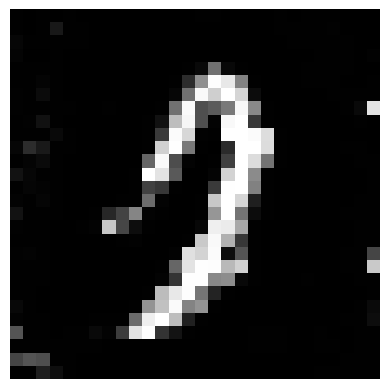

In [17]:
plot_image(gen(z_I))

In [18]:
query_activations = cnn(gen(z_I))[1][0]

3) Constructing a latent dataset for training data (THE FUNCTION IS TIME-CONSUMING!)

In [13]:
# On this step, we construct a latent datset that constitute the logits of the all training data and the corresponding for them predictions 

latent_ds = return_feature_contribution_data(train_dataloader, cnn, num_classes=10)

0.0 % complete...
17.0 % complete...
33.0 % complete...
50.0 % complete...
67.0 % complete...
83.0 % complete...


(!) Pickle calculated activations and their corresponding predictions

In [21]:
latent_ds_path = r'D:\PycharmProjects\XAIRobustness\CARLA_VISUAL\carla_visual\recourse_methods\piece\latent_ds.pickle'
with open(latent_ds_path, 'wb') as handle:
    pickle.dump(latent_ds, handle, protocol=pickle.HIGHEST_PROTOCOL)

(!) Load pre-calculated latent dataset 

In [19]:
latent_ds_path = r'D:\PycharmProjects\XAIRobustness\CARLA_VISUAL\carla_visual\recourse_methods\piece\latent_mnist_dataset.pickle'
with open(latent_ds_path, 'rb') as handle:
    latent_ds = pickle.load(handle)

4) Step 1: Acquire the probability of each features, and identify the excpetional ones (i.e., those with a probability lower than alpha)

In [20]:
alpha = 0.05

In [21]:
df = acquire_feature_probabilities(latent_ds, original_query_label, cnn, original_query_img, alpha)

5) Step 2: Filter out exceptional features which we want to change, and change them to their expected values in the counterfactual class

In [22]:
df_copy = copy.deepcopy(df)
df_new = df_copy[df_copy['Probability of Event'] < alpha]

df_new['flag'] = 0
digit_weights = cnn.classifier[0].weight[original_query_label]

for idx, row in df_new.iterrows():
    feature_idx = int(row['Feature Map'])  

    if row['Bern Fail']:  # if it's unusual to not activate, but it's negative
        if digit_weights[feature_idx] < 0: 
            df_new.at[feature_idx, 'flag'] = 1
    if row['Cont High']:  # if it's high, but positive
        if digit_weights[feature_idx] > 0: 
            df_new.at[feature_idx, 'flag'] = 1
    if row['Cont Low'] :  # if it's low, but negative
        if digit_weights[feature_idx] < 0: 
            df_new.at[feature_idx, 'flag'] = 1

exceptional_noise_idx = df_new[df_new.flag == 0].index.tolist()
print('Exceptions(?): ', df_new[df_new.flag == 1].index.tolist())
df_copy = df_copy.drop(index=exceptional_noise_idx, axis=0)
print('The length of the latent datset before and after filtering:', df.shape, '|', df_copy.shape)
print('Number of noisy exceptional features deleted:', len(exceptional_noise_idx))


Exceptions(?):  [12, 15, 16, 79, 103, 120]
The length of the latent datset before and after filtering: (128, 10) | (51, 10)
Number of noisy exceptional features deleted: 77


C:\Users\sahat\AppData\Local\Temp\ipykernel_19488\1343122470.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['flag'] = 0


In [23]:
# Sort by least probable to the most probable
df_copy = df_copy.sort_values('Probability of Event')

# Get x' -- The Ideal Explanation
ideal_xprime = modifying_exceptional_features(df_copy, original_query_label, query_activations)   
ideal_xprime = ideal_xprime.clone().detach().float().requires_grad_(False)

In [26]:
def optim_PIECE(G, cnn, x_prime, z_e, criterion, optimizer, n_iterations=500):
	"""
	Step 3 of the PIECE algorithm
	returns: z prime
	"""

	for i in range(n_iterations):

		optimizer.zero_grad()
		logits, x_e = cnn(G(z_e))
		loss = criterion(x_e[0], x_prime)

		loss.backward()  
		optimizer.step()  

		if i % 50 == 0:
			print("Loss:", loss.item())

	return z_e

In [27]:
criterion = nn.MSELoss()
optimizer = optim.Adam([z_I], lr=0.001)
z_prime = optim_PIECE(gen, cnn, ideal_xprime, z_I, criterion, optimizer)

Loss: 0.003757352940738201
Loss: 0.0037295534275472164
Loss: 0.0037107300013303757
Loss: 0.003695983439683914
Loss: 0.0036840501707047224
Loss: 0.0036613955162465572
Loss: 0.003633237909525633
Loss: 0.0036094977986067533
Loss: 0.003594815731048584
Loss: 0.0035856107715517282


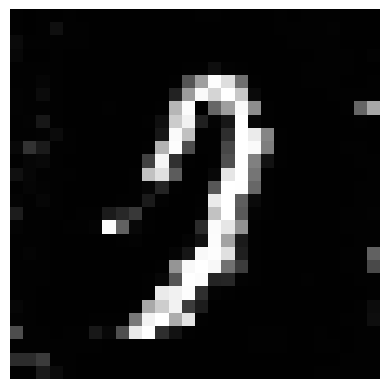

Prediction of the CNN classifier: 7


In [28]:
counterfactual_image = gen(z_prime)
plot_image(counterfactual_image)
print('Prediction of the CNN classifier:', torch.argmax(cnn(counterfactual_image)[0]).numpy())